In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [2]:
# Step 2: Dataset Preparation
# Load dataset
data = pd.read_csv('climate_nasa.csv')

In [3]:
print(data.columns)

Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text'], dtype='object')


In [4]:
print(data.head())

                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                         profileName  commentsCount  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...            NaN   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...            NaN   
2  d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...            3.0   
3  37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...            NaN   
4  e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...           26.0   

                                                text  
0  Neat comparison I have not heard it before.\n ...  
1  An excellent way to visualise the invisible! T...  
2  Does the CO2/ghg in the troposphere affect the...  
3  excellent post! I defo feel the difference - o...  
4  Yes, and carbon dioxide does not har

In [5]:
# Step 3: Data Exploration and Visualization
print("Dataset Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           522 non-null    object 
 1   likesCount     522 non-null    int64  
 2   profileName    522 non-null    object 
 3   commentsCount  244 non-null    float64
 4   text           504 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 20.5+ KB
None

Summary Statistics:
       likesCount  commentsCount
count  522.000000     244.000000
mean     4.720307       8.696721
std     12.053556      12.266176
min      0.000000       1.000000
25%      0.000000       2.000000
50%      1.000000       5.000000
75%      4.000000      10.000000
max    126.000000      93.000000


In [6]:
# Convert 'date' column to datetime type and extract year and month for trend analysis
data['date'] = pd.to_datetime(data['date'])
data['Year'] = data['date'].dt.year
data['Month'] = data['date'].dt.month

In [7]:
print(data.columns)


Index(['date', 'likesCount', 'profileName', 'commentsCount', 'text', 'Year',
       'Month'],
      dtype='object')


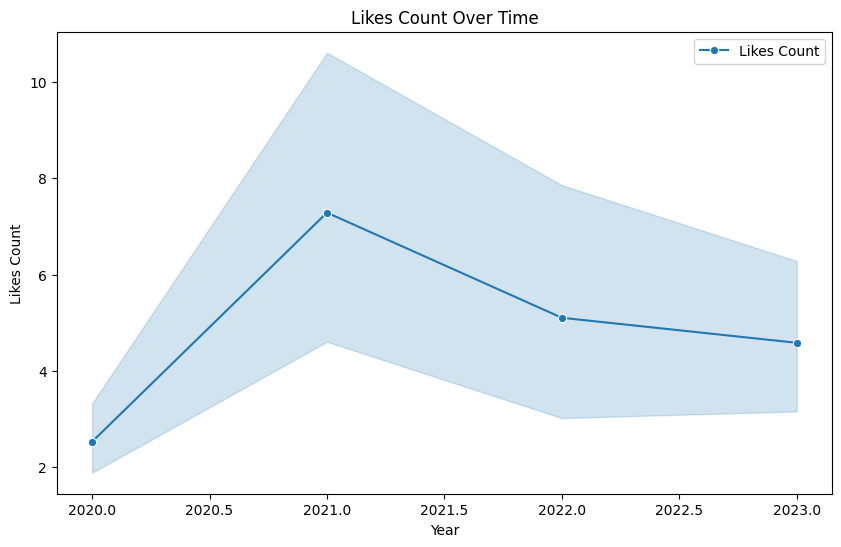

In [8]:
# Visualizations: Likes count and comments count over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Year', y='likesCount', marker="o", label="Likes Count")
plt.title('Likes Count Over Time')
plt.xlabel('Year')
plt.ylabel('Likes Count')
plt.show()


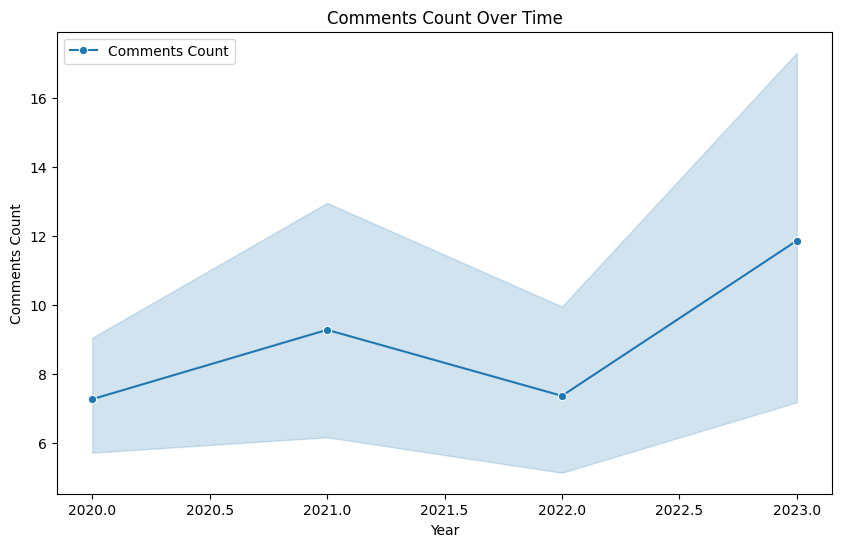

In [9]:
# Visualizations: Comments count over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Year', y='commentsCount', marker="o", label="Comments Count")  # Use commentsCount_x or commentsCount_y
plt.title('Comments Count Over Time')
plt.xlabel('Year')
plt.ylabel('Comments Count')
plt.legend()
plt.show()

In [10]:
numeric_data = data.select_dtypes(include=[np.number])

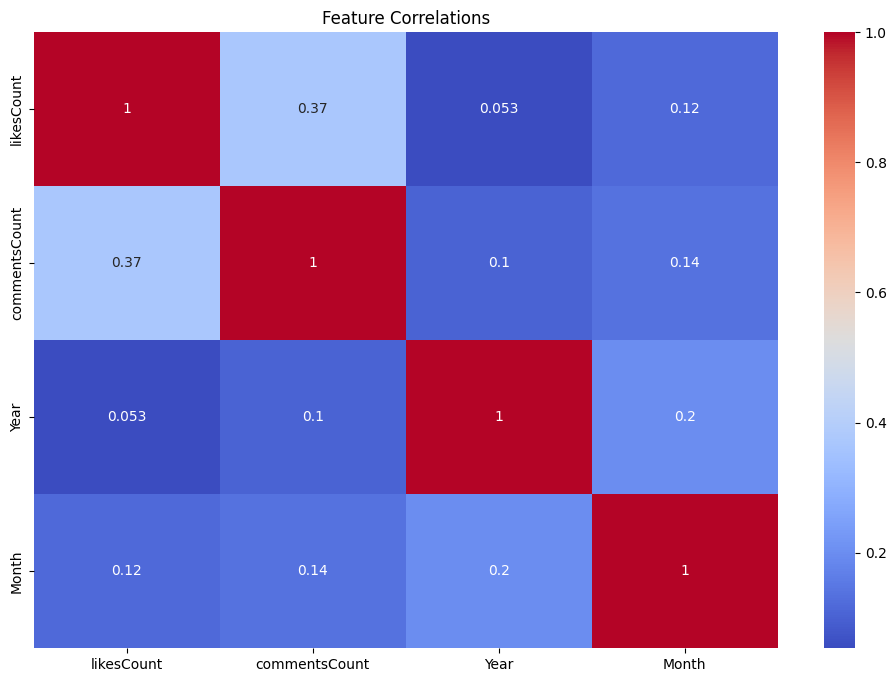

In [11]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

In [12]:
# Step 4: Data Preprocessing
# Separate features (X) and labels (y)
features = ['likesCount', 'commentsCount']
label = 'likesCount'

In [13]:
# Define the features and label columns using the correct suffix (_x or _y)
features = ['commentsCount', 'Year', 'Month']
label = 'likesCount'  # Use the appropriate 'likesCount' column

In [14]:

# Prepare data for prediction
X = data[features]  # Use 'commentsCount', 'Year', and 'Month' to predict likesCount
y = data[label]

In [15]:
# Handle missing values
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [16]:
# Step 5: Feature Engineering
# Creating a lagged variable for likesCount as a predictive feature
y_lagged = y.shift(1)  # Lagged 'likesCount_x'

# Make a copy of X to avoid modifying a slice of the DataFrame
X = X.copy()

# Add the lagged likes column safely
X['LaggedLikes'] = y_lagged

# Handle NaN values due to lag using .bfill() to avoid FutureWarning
X['LaggedLikes'] = X['LaggedLikes'].bfill()

# Ensure that no NaN values remain in the LaggedLikes column
X.fillna(0, inplace=True)  # Optionally, replace any remaining NaNs with 0


In [17]:
# Step 6: Model Selection and Training
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [19]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['commentsCount'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [20]:
# Step 7: Model Evaluation
y_pred = model.predict(X_test)

In [21]:
# Evaluating performance using metrics
print("\nModel Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")


Model Evaluation:
MAE: 5.556978252717233
MSE: 154.90294568021753
R²: 0.13785105730088376


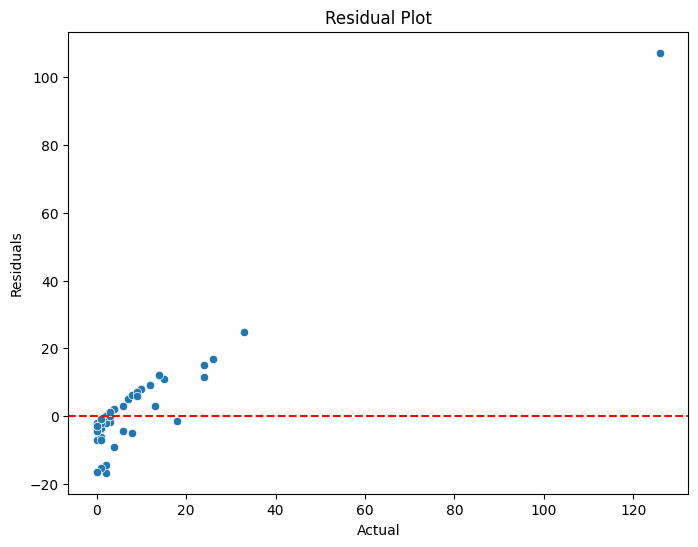

In [22]:
# Residual Plot for diagnostic check
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.show()

In [23]:
# Step 8: Future Projections (Example with mock future data)
# Replace with your own logic or data for future projections
future_data = pd.DataFrame({
    'commentsCount': [120, 130, 140],  # Example values for future data
    'Year': [2024, 2025, 2026],
    'Month': [1, 2, 3],
    'LaggedLikes': [200, 210, 220]  # Previous values for lagged feature
})

In [24]:
# Predict future likesCount using the trained model
future_predictions = model.predict(future_data)
print("\nFuture Predictions:")
print(future_predictions)


Future Predictions:
[31.74 31.74 31.74]


In [25]:
# Step 9: Scenario Analysis (Simulate different comment counts for prediction)
comment_scenarios = [100, 120, 140]
scenario_results = []

for comment_count in comment_scenarios:
    future_data['commentsCount_x'] = comment_count
    prediction = model.predict(future_data)
    scenario_results.append((comment_count, prediction.mean()))

print("\nScenario Analysis Results:")
for scenario in scenario_results:
    print(f"Comments Count: {scenario[0]}, Predicted Avg Likes Count: {scenario[1]:.2f}")


Scenario Analysis Results:
Comments Count: 100, Predicted Avg Likes Count: 31.74
Comments Count: 120, Predicted Avg Likes Count: 31.74
Comments Count: 140, Predicted Avg Likes Count: 31.74


In [ ]:
# Step 10: Deployment
# Save the trained model for deployment
joblib.dump(model, 'limate_change_model.pkl')
print("\nModel saved as 'climate_change_model.pkl'.")


Model saved as 'climate_change_model.pkl'.
